# Financial Model Presentation #

## By Eric Weltz ##

In [1]:
import argparse
import base64
import datetime
import fix_yahoo_finance
import json
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import spacy
import requests
import re
import tensorflow as tf
import util
from bs4 import BeautifulSoup
from collections import OrderedDict, defaultdict
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from keras.utils.np_utils import to_categorical
from matplotlib.dates import DateFormatter, WeekdayLocator,\
    DayLocator, MONDAY
from matplotlib.finance import candlestick_ohlc
from pandas_datareader import data as pdr




Using TensorFlow backend.
/home/ewelt/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the module mpl_finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [2]:
"""Code adapted from https://www.scrapehero.com/scrape-yahoo-finance-stock-market-data/"""

def parse_current_data(ticker):
    url = "http://finance.yahoo.com/quote/%s?p=%s"%(ticker,ticker)
    raw_data = requests.get(url)
    print("Parsing %s"%(url))
    soup = BeautifulSoup(raw_data.text, "lxml")
    summary_table = soup.find_all(class_=re.compile('Bxz\(bb\) Bdbw\(1px\) Bdbs\(s\) Bdc\(\$lightGray\) H\(36px\) '))
    summary_data = OrderedDict()
    other_details_json_link = "https://query2.finance.yahoo.com/v10/finance/quoteSummary/{0}?formatted=true&lang=en-US&region=US&modules=summaryProfile%2CfinancialData%2CrecommendationTrend%2CupgradeDowngradeHistory%2Cearnings%2CdefaultKeyStatistics%2CcalendarEvents&corsDomain=finance.yahoo.com".format(ticker)
    json_response = requests.get(other_details_json_link)
    for table_data in summary_table:
        raw_table_key = table_data.find(class_=re.compile('black'))
        raw_table_value = table_data.find_all(class_=re.compile('end'))
        table_key = ''.join(raw_table_key.text).strip()
        table_value = ''.join(value.text for value in raw_table_value).strip()
        summary_data.update({table_key:table_value})
    summary_data.update({'ticker':ticker,'url':url})
    return summary_data


In [3]:
print(parse_current_data('AAPL'))

Parsing http://finance.yahoo.com/quote/AAPL?p=AAPL
OrderedDict([('Previous Close', '145.87'), ('Open', '145.77'), ('Bid', '145.63 x 500'), ('Ask', '145.75 x 400'), ("Day's Range", '145.12 - 146.70'), ('52 Week Range', '91.50 - 156.65'), ('Volume', '19,106,294'), ('Avg. Volume', '26,957,307'), ('Market Cap', '759.29B'), ('Beta', '1.43'), ('PE Ratio (TTM)', '17.08'), ('EPS (TTM)', '8.52'), ('Earnings Date', 'Jul 24, 2017 - Jul 28, 2017'), ('Dividend & Yield', '2.52 (1.74%)'), ('Ex-Dividend Date', '2017-05-11'), ('1y Target Est', '157.58'), ('ticker', 'AAPL'), ('url', 'http://finance.yahoo.com/quote/AAPL?p=AAPL')])


In [4]:
def parse_historical_data(ticker):
    # We will look at stock prices over the past year, starting at January 1, 2016
    start = datetime.date(2006, 10, 21)
    end = datetime.date(2013, 11, 27)
 
    # Let's get Apple stock data; Apple's ticker symbol is AAPL
    # First argument is the series we want, second is the source ("yahoo" for Yahoo! Finance), third is the start date, fourth is the end date
    stock = pdr.get_data_yahoo(ticker, start, end)
    return stock
 


In [5]:
def make_plot(table):
    %matplotlib inline
    %pylab inline
    pylab.rcParams['figure.figsize'] = (15, 9)   
 
    table["Adj Close"].plot(grid = True) 

In [6]:
def pandas_candlestick_ohlc(dat, stick = "day", otherseries = None, days=1):
    """
    Code from https://ntguardian.wordpress.com/2016/09/19/introduction-stock-market-data-python-1/
    :param dat: pandas DataFrame object with datetime64 index, and float columns "Open", "High", "Low", and "Close", likely created via DataReader from "yahoo"
    :param stick: A string or number indicating the period of time covered by a single candlestick. Valid string inputs include "day", "week", "month", and "year", ("day" default), and any numeric input indicates the number of trading days included in a period
    :param otherseries: An iterable that will be coerced into a list, containing the columns of dat that hold other series to be plotted as lines
 
    This will show a Japanese candlestick plot for stock data stored in dat, also plotting other series if passed.
    """
    mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
    alldays = DayLocator()              # minor ticks on the days
    dayFormatter = DateFormatter('%d')      # e.g., 12
 
    # Create a new DataFrame which includes OHLC data for each period specified by stick input
    transdat = dat.loc[:,["Open", "High", "Low", "Close"]]
    if (type(stick) == str):
        if stick == "day":
            plotdat = transdat
            stick = 1 # Used for plotting
        elif stick in ["week", "month", "year"]:
            if stick == "week":
                transdat["week"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[1]) # Identify weeks
            elif stick == "month":
                transdat["month"] = pd.to_datetime(transdat.index).map(lambda x: x.month) # Identify months
            transdat["year"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[0]) # Identify years
            grouped = transdat.groupby(list(set(["year",stick]))) # Group by year and other appropriate variable
            plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
            for name, group in grouped:
                plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                            "High": max(group.High),
                                            "Low": min(group.Low),
                                            "Close": group.iloc[-1,3]},
                                           index = [group.index[0]]))
            if stick == "week": stick = 5
            elif stick == "month": stick = 30
            elif stick == "year": stick = 365
 
    elif (type(stick) == int and stick >= 1):
        transdat["stick"] = [np.floor(i / stick) for i in range(len(transdat.index))]
        grouped = transdat.groupby("stick")
        plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
        for name, group in grouped:
            plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                        "High": max(group.High),
                                        "Low": min(group.Low),
                                        "Close": group.iloc[-1,3]},
                                       index = [group.index[0]]))
 
    else:
        raise ValueError('Valid inputs to argument "stick" include the strings "day", "week", "month", "year", or a positive integer')
 
 
    # Set plot parameters, including the axis object ax used for plotting
    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.2)
    if plotdat.index[-1] - plotdat.index[0] < pd.Timedelta('730 days'):
        weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
        ax.xaxis.set_major_locator(mondays)
        ax.xaxis.set_minor_locator(alldays)
    else:
        weekFormatter = DateFormatter('%b %d, %Y')
    ax.xaxis.set_major_formatter(weekFormatter)
 
    ax.grid(True)
 
    # Create the candelstick chart
    zipped_list = list(zip(list(date2num(plotdat.index.tolist())), plotdat["Open"].tolist(), plotdat["High"].tolist(),
                      plotdat["Low"].tolist(), plotdat["Close"].tolist()))
    if days == 1:
        days=len(zipped_list)
    candlestick_ohlc(ax, zipped_list[len(zipped_list)-days:],
                      colorup = "black", colordown = "red", width = stick * .4)
 
    # Plot other series (such as moving averages) as lines
    if otherseries != None:
        if type(otherseries) != list:
            otherseries = [otherseries]
        dat.loc[:,otherseries].plot(ax = ax, lw = 1.3, grid = True)
 
    ax.xaxis_date()
    ax.autoscale_view()
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
 
    plt.show()

In [7]:
def collect_data(ticker):
    table = parse_historical_data(ticker)
    make_plot(table)
    pandas_candlestick_ohlc(table, days=365)
    return table

[*********************100%***********************]  1 of 1 downloadedPopulating the interactive namespace from numpy and matplotlib


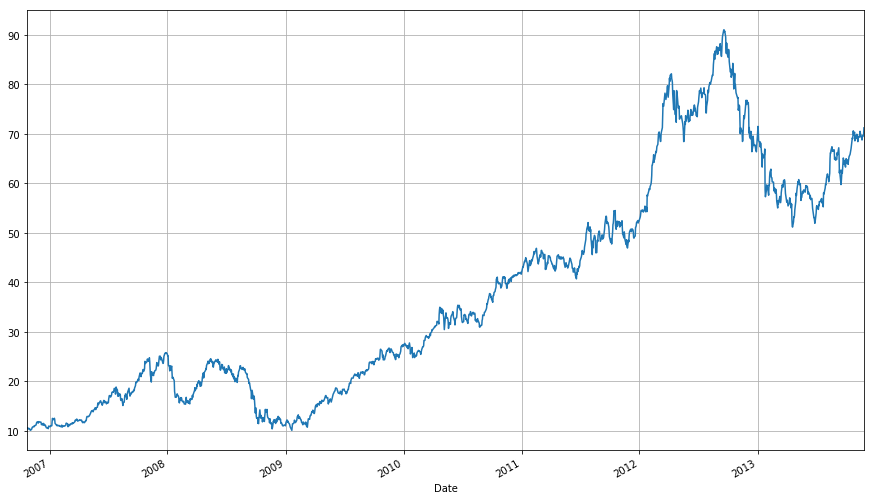

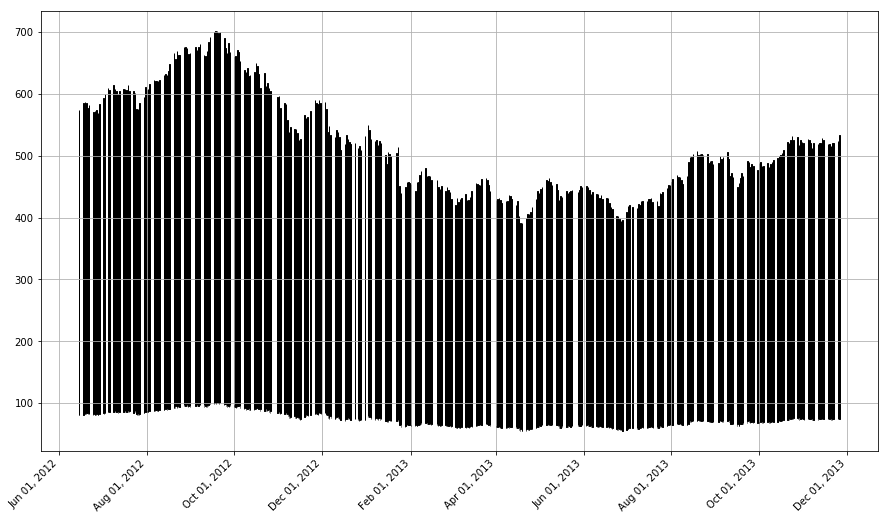

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2006-10-23,11.427143,11.700000,11.392858,81.459999,10.510538,208126800
2006-10-24,11.601429,11.668571,11.457143,81.050003,10.457637,115803100
2006-10-25,11.621428,11.714286,11.572857,81.680000,10.538924,121303700
2006-10-26,11.700000,11.800000,11.590000,82.190002,10.604730,108189200
2006-10-27,11.678572,11.778571,11.430000,80.409996,10.375060,148741600
2006-10-30,11.427143,11.557143,11.357142,80.419998,10.376348,124979400
2006-10-31,11.635715,11.668571,11.461429,81.080002,10.461510,125368600
2006-11-01,11.585714,11.625714,11.194285,79.160004,10.213779,152798100
2006-11-02,11.274285,11.331429,11.214286,78.979996,10.190552,116370800


In [8]:
collect_data('AAPL')

# PowerShares Dyn Leisure & Entert. (ETF)#

* Comprised of 30 common stocks of United States Entertainment and Leisure Companies
* Companies in design and production of goods and services in these industries
* Rebalanced on a quarterly basis

[*********************100%***********************]  1 of 1 downloadedPopulating the interactive namespace from numpy and matplotlib


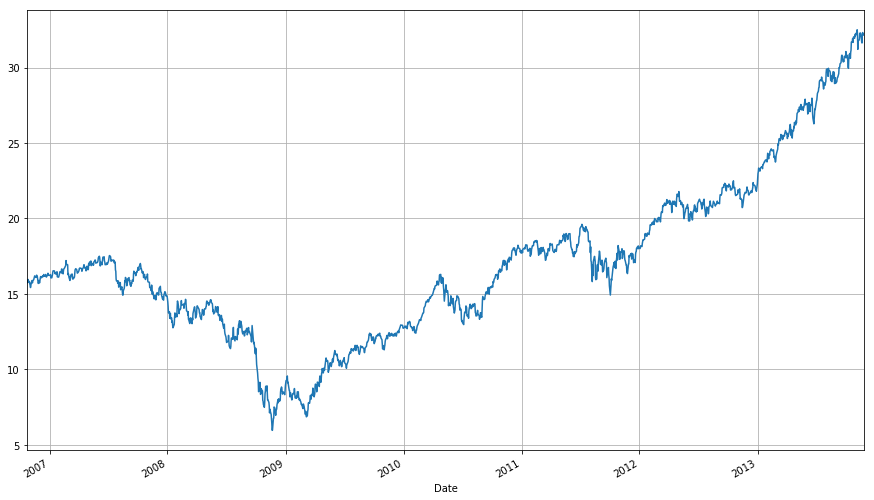

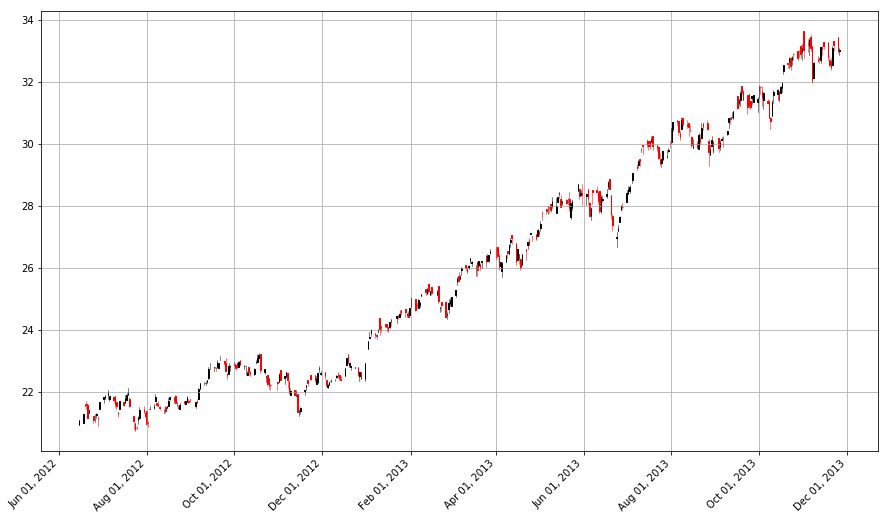

In [9]:
pej_table = collect_data('PEJ')

## Get the price changes and dates over the span of the period of the data set ##

In [10]:
def get_open(table):
    return table['Open']
def get_close(table):
    return table['Adj_Close']
def get_date(table):
    return table.index.values

In [15]:
opn = np.append(np.asarray(get_open(pej_table).tolist()), 0)
close = np.insert(np.asarray(get_open(pej_table).tolist()), 0, 0)
dates = np.asarray(get_date(pej_table).tolist())

In [16]:
new_dates = []
for date in dates:
    new_date = datetime.datetime.fromtimestamp(date/10**9).strftime('%Y%m%d')
    new_dates.append(new_date)


In [20]:
daily_change = numpy.delete(close - opn,0)

In [21]:
daily_change

array([ -0.120001,  -0.25    ,   0.040001, ...,  -0.11    ,   0.43    ,
        33.      ])

## Data Retrieval and Combination ##

In [22]:
def get_data_reuters():
    files = defaultdict(list)
    for dirpath, dirnames, filenames in os.walk("/home/ewelt/financial-news-dataset/ReutersNews106521"):
        for dirname in [d for d in dirnames]:
            directory = os.path.join(dirpath, dirname)
            for dirpath2, dirnames2, filenames2 in os.walk(directory):
                for filename in [f for f in filenames2]:
                    file = os.path.join(dirpath2, filename)
                    files[dirname].append(file)
    return files

In [23]:
def get_data_bloomberg():
    files = defaultdict(list)
    for dirpath, dirnames, filenames in os.walk("/home/ewelt/financial-news-dataset/20061020_20131126_bloomberg_news"):
        for dirname in [d for d in dirnames]:
            directory = os.path.join(dirpath, dirname)
            for dirpath2, dirnames2, filenames2 in os.walk(directory):
                for filename in [f for f in filenames2]:
                    file = os.path.join(dirpath2, filename)
                    files[dirname.replace('-', '')].append(file)
    return files

In [24]:
reuters = get_data_reuters()

In [25]:
bloomberg = get_data_bloomberg()

In [26]:
def combine(d1, d2):
    for key,value in d1.items():
        d2[key].extend(value)
    return d2

In [27]:
links_comb = combine(reuters, bloomberg)

In [28]:
price_change_dict = {}
for i in range(1761):
    price_change_dict[new_dates[i]] = daily_change[i]


In [29]:
dates_list = list(price_change_dict.keys())

In [30]:
nlp = spacy.load('en')



    Only loading the 'en' tokenizer.



In [31]:
for date in dates_list:
    if (datetime.datetime.strptime(date, '%Y%m%d') - datetime.timedelta(days=1)).strftime('%Y%m%d') not in list(set(list(reuters.keys()) + list(links_comb.keys()))):
        dates_list.remove(date)
        price_change_dict.pop(date)
        


In [32]:
new_links = defaultdict(list)
for key in list(set(list(reuters.keys()) + list(links_comb.keys()))):
    if (datetime.datetime.strptime(key, '%Y%m%d') + datetime.timedelta(days=1)).strftime('%Y%m%d') in dates_list:
        new_links[key] = links_comb[key]


In [33]:
train_x = [new_links[key] for key in list(sort(list(new_links.keys())))]

In [34]:
train_y = list(price_change_dict.values())

In [35]:
def process_articles(l):
    new_list = []
    for minilist in l:
        lst = []
        for link in minilist:
            with open(link, 'rb') as f:
                text = nlp(str(f.read()))
            lst.append(text)
        new_list.append(lst)
    return new_list
    

In [36]:
processed_train = process_articles(train_x[:600])

In [37]:
processed_test = process_articles(train_x[600:900])

In [38]:
#processed_test_future = processed_train = process_articles(train_x[1600:])

In [39]:
# Convert text to integer symbols
symbol_table = util.SymbolTable()

def preprocess_text(parsed_text, symbol_table, init=True):
    mapper = symbol_table.lookup_add if init else symbol_table.lookup
    return [[mapper(w.text.strip().lower()) for s in t for w in s] for t in parsed_text]

In [40]:
symbols = preprocess_text(processed_train, symbol_table, True)
symbols_test = preprocess_text(processed_test, symbol_table, False)    


In [ ]:
MAX_LENGTH = 300
x_train = sequence.pad_sequences(symbols, maxlen=MAX_LENGTH)
x_test = sequence.pad_sequences(symbols_test, maxlen=MAX_LENGTH)

# Create Categories #

In [72]:
def categorize(value):
    if value < -.3:
        return 0
    elif value < -.05:
        return 1
    elif value < .05:
        return 2
    elif value < .3:
        return 3
    else:
        return 4
    

# **Train a Dope Model** #

In [73]:
train_categories = [categorize(value) for value in train_y[:600]]
processed_test_categories = [categorize(value) for value in train_y[600:900]]
processed_test_future_categories = [categorize(value) for value in train_y[1600:]]

In [74]:
max_features = len(list(set([i for lst in symbols for i in lst])))+50
batch_size = 20

In [91]:
model = Sequential()
model.add(Embedding(max_features, 64, input_length=MAX_LENGTH))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.8))

model.add(Dense(5, activation='softmax'))

# try using different optimizers and different optimizer configs
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

In [92]:
print('Train...')
model.fit(x_train, to_categorical(train_categories),
          batch_size=batch_size,
          epochs=5,
          validation_data=[x_test, to_categorical(processed_test_categories)])

Train...
Train on 600 samples, validate on 300 samples
Epoch 1/5
600/600 [==============================] - 18s - loss: 1.5974 - acc: 0.2467 - val_loss: 1.5752 - val_acc: 0.2633
Epoch 2/5
600/600 [==============================] - 16s - loss: 1.5658 - acc: 0.3133 - val_loss: 1.5330 - val_acc: 0.2567
Epoch 3/5
600/600 [==============================] - 16s - loss: 1.5229 - acc: 0.3383 - val_loss: 1.4891 - val_acc: 0.3533
Epoch 4/5
600/600 [==============================] - 16s - loss: 1.4521 - acc: 0.3550 - val_loss: 1.5193 - val_acc: 0.2600
Epoch 5/5
600/600 [==============================] - 16s - loss: 1.3297 - acc: 0.4617 - val_loss: 1.5695 - val_acc: 0.2633


In [93]:
predictions = model.predict(x_test)

### Probability Predictions for the five categories ### 

In [95]:
predictions

array([[ 0.16906859,  0.16807295,  0.21045032,  0.2638194 ,  0.18858874],
       [ 0.15634032,  0.19052267,  0.14817163,  0.28193447,  0.22303094],
       [ 0.16797596,  0.16272312,  0.19547197,  0.25352284,  0.22030608],
       ..., 
       [ 0.1400114 ,  0.20696539,  0.19610174,  0.29796705,  0.15895435],
       [ 0.12129099,  0.18275549,  0.15240672,  0.34810027,  0.19544652],
       [ 0.16619219,  0.15640394,  0.17178394,  0.2990045 ,  0.20661537]], dtype=float32)